In [1]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 4.0 MB/s 
     |████████████████████████████████| 4.0 MB 10.5 MB/s 
     |████████████████████████████████| 1.2 MB 56.2 MB/s 
     |████████████████████████████████| 77 kB 7.4 MB/s 
     |████████████████████████████████| 596 kB 67.7 MB/s 
     |████████████████████████████████| 6.6 MB 81.0 MB/s 
     |████████████████████████████████| 880 kB 69.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=bc1f08ec12faba416cb0c110e52afe2c58c08550402a32e7e92de70d2944c0d6
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=cbf6fb4f0eb834ab29d987f2ab44f87ea04fc7ea999a68755ddfb8be177244f4
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sentence-transformers sa

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [4]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, 1.)

        target = target / target.sum()  # Normalise

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [8]:
articles_df = pd.read_csv('data/articles_df_filt.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(40538, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0110065001,"Microfibre T-shirt bra with underwired, moulde...",2
3,0110065002,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065011,"Microfibre T-shirt bra with underwired, moulde...",4


In [9]:
customers = pd.read_csv('data/customers_filt.csv')
print(customers.shape)
customers.head()

(43108, 5)


,customer_id,FN,Active,age,customer_id_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,0.45,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,0.44,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,0.21,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0.0,0.0,0.21,4


### Create article EmbeddingBag

In [10]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [11]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [12]:
embeddings = model.encode(article_descriptions)

In [13]:
embeddings = torch.tensor(embeddings)

In [14]:
embeddings.shape

torch.Size([40538, 384])

In [15]:
ARTICLE_EMBEDDING_BAG = nn.EmbeddingBag.from_pretrained(embeddings=embeddings, freeze=True)

### Model

In [16]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)        
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+384+3, out_features=2048)            
        self.fc_2 = nn.Linear(in_features=2048, out_features=1024)
        # self.fc_3 = nn.Linear(in_features=1024, out_features=512)
        self.fc_3 = nn.Linear(in_features=1024, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.01)
        
    def forward(
        self, 
        customer_id_idx, 
        inputs
    ):

        user_emb = self.user_embeddings(customer_id_idx)
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                inputs
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc_4(x)

        return x

In [17]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [18]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(43108, 384)
  (fc_1): Linear(in_features=771, out_features=2048, bias=True)
  (fc_2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=40538, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

In [19]:
BATCH_SIZE = 1024

In [20]:
total_training_examples = pd.read_csv('data/final_train_set.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

43.0

In [21]:
total_dev_examples = pd.read_csv('data/final_dev_set.tsv', sep='\t').shape[0]
total_dev_batches = np.ceil(total_dev_examples/BATCH_SIZE)
total_dev_batches

9.0

In [22]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.001)  # 0.0001
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [23]:
MAX_EPOCHS = 75

training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        loss = criterion(y_pred, label)

        loss.backward()    
        
        optimizer.step()
        
    # scheduler.step()
    
    # Compute train loss:
    
    total_train_loss = 0

    fashion_rec_v3.eval()
    
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(train_loader, total=total_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            # loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / total_training_examples
        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
        
    # Compute dev loss:
    
    total_dev_loss = 0
    
    dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(dev_loader, total=total_dev_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            # optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            # loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_dev_loss += loss.item()

        mean_dev_loss = total_train_loss / total_dev_examples
        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
        
    fashion_rec_v3.train()

100%|██████████| 43/43.0 [00:11<00:00,  3.71it/s]
100%|██████████| 43/43.0 [00:13<00:00,  3.18it/s]


Training loss: 8.635563869074566


100%|██████████| 9/9.0 [00:02<00:00,  3.29it/s]


Dev loss: 40.818189393428334


100%|██████████| 43/43.0 [00:11<00:00,  3.75it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 8.39989198668941


100%|██████████| 9/9.0 [00:02<00:00,  3.36it/s]


Dev loss: 39.704226289715685


100%|██████████| 43/43.0 [00:11<00:00,  3.81it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.37it/s]


Training loss: 8.35131736543699


100%|██████████| 9/9.0 [00:02<00:00,  3.35it/s]


Dev loss: 39.47462598566423


100%|██████████| 43/43.0 [00:11<00:00,  3.80it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.44it/s]


Training loss: 8.272096074467036


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 39.1001664011102


100%|██████████| 43/43.0 [00:11<00:00,  3.75it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.38it/s]


Training loss: 8.18521312704066


100%|██████████| 9/9.0 [00:02<00:00,  3.32it/s]


Dev loss: 38.68949204829701


100%|██████████| 43/43.0 [00:11<00:00,  3.82it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 8.125391588921648


100%|██████████| 9/9.0 [00:02<00:00,  3.27it/s]


Dev loss: 38.406730330617805


100%|██████████| 43/43.0 [00:11<00:00,  3.82it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.40it/s]


Training loss: 7.853454843283783


100%|██████████| 9/9.0 [00:02<00:00,  3.33it/s]


Dev loss: 37.12135212546901


100%|██████████| 43/43.0 [00:11<00:00,  3.70it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.44it/s]


Training loss: 8.250088498711177


100%|██████████| 9/9.0 [00:02<00:00,  3.30it/s]


Dev loss: 38.996141995881736


100%|██████████| 43/43.0 [00:11<00:00,  3.76it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.36it/s]


Training loss: 7.783100612046071


100%|██████████| 9/9.0 [00:02<00:00,  3.31it/s]


Dev loss: 36.78880495439496


100%|██████████| 43/43.0 [00:11<00:00,  3.73it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 7.546725490202297


100%|██████████| 9/9.0 [00:02<00:00,  3.26it/s]


Dev loss: 35.67151781048691


100%|██████████| 43/43.0 [00:11<00:00,  3.70it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 7.273531629610694


100%|██████████| 9/9.0 [00:02<00:00,  3.40it/s]


Dev loss: 34.38019753171687


100%|██████████| 43/43.0 [00:11<00:00,  3.81it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.35it/s]


Training loss: 7.174573088616999


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 33.912444814046225


100%|██████████| 43/43.0 [00:11<00:00,  3.70it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 6.621931727525198


100%|██████████| 9/9.0 [00:02<00:00,  3.37it/s]


Dev loss: 31.30024483663994


100%|██████████| 43/43.0 [00:11<00:00,  3.73it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.37it/s]


Training loss: 6.543219923939899


100%|██████████| 9/9.0 [00:02<00:00,  3.39it/s]


Dev loss: 30.928193473815917


100%|██████████| 43/43.0 [00:11<00:00,  3.61it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.41it/s]


Training loss: 7.0172555354814685


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 33.16884337977359


100%|██████████| 43/43.0 [00:11<00:00,  3.70it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 6.4562935766775995


100%|██████████| 9/9.0 [00:02<00:00,  3.16it/s]


Dev loss: 30.517313980637937


100%|██████████| 43/43.0 [00:11<00:00,  3.83it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.36it/s]


Training loss: 5.783663237593751


100%|██████████| 9/9.0 [00:02<00:00,  3.26it/s]


Dev loss: 27.337955575240287


100%|██████████| 43/43.0 [00:11<00:00,  3.76it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.33it/s]


Training loss: 5.733978158215086


100%|██████████| 9/9.0 [00:02<00:00,  3.30it/s]


Dev loss: 27.10310640837017


100%|██████████| 43/43.0 [00:11<00:00,  3.73it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.31it/s]


Training loss: 5.537516212091714


100%|██████████| 9/9.0 [00:02<00:00,  3.29it/s]


Dev loss: 26.174479042856316


100%|██████████| 43/43.0 [00:11<00:00,  3.68it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.37it/s]


Training loss: 5.1961379428625305


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 24.560867811504163


100%|██████████| 43/43.0 [00:11<00:00,  3.71it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.34it/s]


Training loss: 4.849993207099167


100%|██████████| 9/9.0 [00:02<00:00,  3.29it/s]


Dev loss: 22.924726663556015


100%|██████████| 43/43.0 [00:11<00:00,  3.66it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.35it/s]


Training loss: 4.444187963917026


100%|██████████| 9/9.0 [00:02<00:00,  3.33it/s]


Dev loss: 21.006584950497277


100%|██████████| 43/43.0 [00:11<00:00,  3.68it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.35it/s]


Training loss: 4.049377971648108


100%|██████████| 9/9.0 [00:02<00:00,  3.32it/s]


Dev loss: 19.140415087917393


100%|██████████| 43/43.0 [00:11<00:00,  3.76it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.34it/s]


Training loss: 4.108883038206049


100%|██████████| 9/9.0 [00:02<00:00,  3.27it/s]


Dev loss: 19.421680922257273


100%|██████████| 43/43.0 [00:11<00:00,  3.73it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.35it/s]


Training loss: 3.8975778140616435


100%|██████████| 9/9.0 [00:02<00:00,  3.33it/s]


Dev loss: 18.42289302725541


100%|██████████| 43/43.0 [00:11<00:00,  3.73it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.31it/s]


Training loss: 3.4914139624350784


100%|██████████| 9/9.0 [00:02<00:00,  3.25it/s]


Dev loss: 16.50305626015914


100%|██████████| 43/43.0 [00:11<00:00,  3.70it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.36it/s]


Training loss: 3.4903540730288336


100%|██████████| 9/9.0 [00:02<00:00,  3.31it/s]


Dev loss: 16.498046423259535


100%|██████████| 43/43.0 [00:11<00:00,  3.65it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 3.2048116306808625


100%|██████████| 9/9.0 [00:02<00:00,  3.31it/s]


Dev loss: 15.14835743151213


100%|██████████| 43/43.0 [00:11<00:00,  3.70it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.37it/s]


Training loss: 3.3081881655958263


100%|██████████| 9/9.0 [00:02<00:00,  3.11it/s]


Dev loss: 15.63699292132729


100%|██████████| 43/43.0 [00:11<00:00,  3.77it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.36it/s]


Training loss: 3.047799232442558


100%|██████████| 9/9.0 [00:02<00:00,  3.28it/s]


Dev loss: 14.406198389488354


100%|██████████| 43/43.0 [00:11<00:00,  3.74it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.35it/s]


Training loss: 2.6603167709884366


100%|██████████| 9/9.0 [00:02<00:00,  3.32it/s]


Dev loss: 12.574663965325607


100%|██████████| 43/43.0 [00:11<00:00,  3.72it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.40it/s]


Training loss: 2.524713502961607


100%|██████████| 9/9.0 [00:02<00:00,  3.29it/s]


Dev loss: 11.933700623428612


100%|██████████| 43/43.0 [00:11<00:00,  3.63it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.38it/s]


Training loss: 2.491616702073136


100%|██████████| 9/9.0 [00:02<00:00,  3.28it/s]


Dev loss: 11.777260174667626


100%|██████████| 43/43.0 [00:11<00:00,  3.75it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.34it/s]


Training loss: 2.4776519714508383


100%|██████████| 9/9.0 [00:02<00:00,  3.32it/s]


Dev loss: 11.71125232294986


100%|██████████| 43/43.0 [00:11<00:00,  3.62it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.31it/s]


Training loss: 2.2968118360890544


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 10.85646541997006


100%|██████████| 43/43.0 [00:11<00:00,  3.67it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.34it/s]


Training loss: 2.283050519057082


100%|██████████| 9/9.0 [00:02<00:00,  3.28it/s]


Dev loss: 10.791419054332533


100%|██████████| 43/43.0 [00:11<00:00,  3.69it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.34it/s]


Training loss: 2.0953069196469025


100%|██████████| 9/9.0 [00:02<00:00,  3.26it/s]


Dev loss: 9.904001172383627


100%|██████████| 43/43.0 [00:11<00:00,  3.73it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 1.9411177156010684


100%|██████████| 9/9.0 [00:02<00:00,  3.36it/s]


Dev loss: 9.175186675891542


100%|██████████| 43/43.0 [00:11<00:00,  3.77it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.38it/s]


Training loss: 1.9618030642604767


100%|██████████| 9/9.0 [00:02<00:00,  3.26it/s]


Dev loss: 9.272961238392613


100%|██████████| 43/43.0 [00:11<00:00,  3.73it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 1.8738954410798985


100%|██████████| 9/9.0 [00:02<00:00,  3.10it/s]


Dev loss: 8.857443494964064


100%|██████████| 43/43.0 [00:11<00:00,  3.77it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.37it/s]


Training loss: 1.7499410932444792


100%|██████████| 9/9.0 [00:02<00:00,  3.40it/s]


Dev loss: 8.271541737673575


100%|██████████| 43/43.0 [00:11<00:00,  3.82it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.38it/s]


Training loss: 1.6346906071040188


100%|██████████| 9/9.0 [00:02<00:00,  3.26it/s]


Dev loss: 7.726780996824566


100%|██████████| 43/43.0 [00:11<00:00,  3.76it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.38it/s]


Training loss: 1.5959693945503926


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 7.543755335556833


100%|██████████| 43/43.0 [00:11<00:00,  3.65it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.36it/s]


Training loss: 1.5869482078810642


100%|██████████| 9/9.0 [00:02<00:00,  3.27it/s]


Dev loss: 7.501114401900978


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 1.5631381993480922


100%|██████████| 9/9.0 [00:02<00:00,  3.30it/s]


Dev loss: 7.38857033963789


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 1.511412937963917


100%|██████████| 9/9.0 [00:02<00:00,  3.35it/s]


Dev loss: 7.144077733525059


100%|██████████| 43/43.0 [00:11<00:00,  3.74it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 1.5112955916886914


100%|██████████| 9/9.0 [00:02<00:00,  3.35it/s]


Dev loss: 7.14352306650396


100%|██████████| 43/43.0 [00:11<00:00,  3.85it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.35it/s]


Training loss: 1.443989924954452


100%|██████████| 9/9.0 [00:02<00:00,  3.32it/s]


Dev loss: 6.825385711067601


100%|██████████| 43/43.0 [00:11<00:00,  3.76it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.37it/s]


Training loss: 1.3869766942576685


100%|██████████| 9/9.0 [00:02<00:00,  3.17it/s]


Dev loss: 6.555898172813549


100%|██████████| 43/43.0 [00:11<00:00,  3.67it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.37it/s]


Training loss: 1.3764249991538784


100%|██████████| 9/9.0 [00:02<00:00,  3.31it/s]


Dev loss: 6.506022901702345


100%|██████████| 43/43.0 [00:11<00:00,  3.60it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.40it/s]


Training loss: 1.382112547474557


100%|██████████| 9/9.0 [00:02<00:00,  3.33it/s]


Dev loss: 6.532906545672501


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.44it/s]


Training loss: 1.3731339240412639


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 6.490466797979255


100%|██████████| 43/43.0 [00:11<00:00,  3.75it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 1.3367587005736998


100%|██████████| 9/9.0 [00:02<00:00,  3.20it/s]


Dev loss: 6.318530050913493


100%|██████████| 43/43.0 [00:11<00:00,  3.81it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.38it/s]


Training loss: 1.3035880058099556


100%|██████████| 9/9.0 [00:02<00:00,  3.21it/s]


Dev loss: 6.161740323953461


100%|██████████| 43/43.0 [00:11<00:00,  3.71it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.36it/s]


Training loss: 1.2776314543474248


100%|██████████| 9/9.0 [00:02<00:00,  3.22it/s]


Dev loss: 6.0390500804834195


100%|██████████| 43/43.0 [00:11<00:00,  3.73it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.41it/s]


Training loss: 1.2539602617524137


100%|██████████| 9/9.0 [00:02<00:00,  3.40it/s]


Dev loss: 5.927162167063931


100%|██████████| 43/43.0 [00:11<00:00,  3.85it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.38it/s]


Training loss: 1.2358520212604416


100%|██████████| 9/9.0 [00:02<00:00,  3.43it/s]


Dev loss: 5.841568961896394


100%|██████████| 43/43.0 [00:11<00:00,  3.72it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 1.2270530715904155


100%|██████████| 9/9.0 [00:02<00:00,  3.37it/s]


Dev loss: 5.799978487951714


100%|██████████| 43/43.0 [00:11<00:00,  3.76it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.41it/s]


Training loss: 1.2130517463156671


100%|██████████| 9/9.0 [00:02<00:00,  3.38it/s]


Dev loss: 5.733797662299976


100%|██████████| 43/43.0 [00:11<00:00,  3.78it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.41it/s]


Training loss: 1.1949347674520336


100%|██████████| 9/9.0 [00:02<00:00,  3.35it/s]


Dev loss: 5.6481631529958625


100%|██████████| 43/43.0 [00:11<00:00,  3.80it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.44it/s]


Training loss: 1.1683357003735757


100%|██████████| 9/9.0 [00:02<00:00,  3.18it/s]


Dev loss: 5.522435896020187


100%|██████████| 43/43.0 [00:11<00:00,  3.81it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 1.150206796731601


100%|██████████| 9/9.0 [00:02<00:00,  3.37it/s]


Dev loss: 5.436745021217748


100%|██████████| 43/43.0 [00:11<00:00,  3.86it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.41it/s]


Training loss: 1.1458146703301881


100%|██████████| 9/9.0 [00:02<00:00,  3.29it/s]


Dev loss: 5.415984518486157


100%|██████████| 43/43.0 [00:11<00:00,  3.74it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.38it/s]


Training loss: 1.1315006175753113


100%|██████████| 9/9.0 [00:02<00:00,  3.35it/s]


Dev loss: 5.34832550684611


100%|██████████| 43/43.0 [00:11<00:00,  3.73it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.46it/s]


Training loss: 1.12630799056272


100%|██████████| 9/9.0 [00:02<00:00,  3.38it/s]


Dev loss: 5.3237812343396635


100%|██████████| 43/43.0 [00:11<00:00,  3.77it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.38it/s]


Training loss: 1.1188629977256432


100%|██████████| 9/9.0 [00:02<00:00,  3.35it/s]


Dev loss: 5.288590581793534


100%|██████████| 43/43.0 [00:11<00:00,  3.77it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 1.1125774438409735


100%|██████████| 9/9.0 [00:02<00:00,  3.33it/s]


Dev loss: 5.258880312400952


100%|██████████| 43/43.0 [00:11<00:00,  3.82it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 1.1170577093235712


100%|██████████| 9/9.0 [00:02<00:00,  3.21it/s]


Dev loss: 5.2800574269211085


100%|██████████| 43/43.0 [00:11<00:00,  3.81it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 1.1007115903077236


100%|██████████| 9/9.0 [00:02<00:00,  3.28it/s]


Dev loss: 5.202793337169447


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 1.095439946462308


100%|██████████| 9/9.0 [00:02<00:00,  3.36it/s]


Dev loss: 5.1778755715018825


100%|██████████| 43/43.0 [00:11<00:00,  3.78it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 1.0876494513224326


100%|██████████| 9/9.0 [00:02<00:00,  3.31it/s]


Dev loss: 5.1410518144306385


100%|██████████| 43/43.0 [00:11<00:00,  3.76it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.38it/s]


Training loss: 1.0722205459468714


100%|██████████| 9/9.0 [00:02<00:00,  3.29it/s]


Dev loss: 5.068123168276068


100%|██████████| 43/43.0 [00:11<00:00,  3.77it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.40it/s]


Training loss: 1.0625629248065565


100%|██████████| 9/9.0 [00:02<00:00,  3.33it/s]


Dev loss: 5.022473965193096


100%|██████████| 43/43.0 [00:11<00:00,  3.71it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.32it/s]


Training loss: 1.0671804070063444


100%|██████████| 9/9.0 [00:02<00:00,  3.36it/s]


Dev loss: 5.044299669433058


100%|██████████| 43/43.0 [00:11<00:00,  3.71it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.35it/s]


Training loss: 1.0693262526218443


100%|██████████| 9/9.0 [00:02<00:00,  3.27it/s]

Dev loss: 5.054442554607726


In [24]:
training_losses[-1], dev_losses[-1]

(1.0693262526218443, 5.054442554607726)

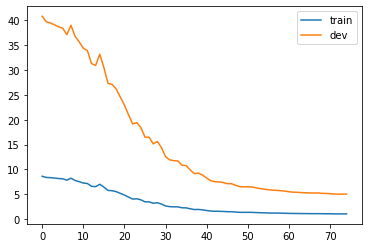

In [25]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### MAP@12

#### Train

In [107]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 43/43.0 [00:11<00:00,  3.73it/s]


In [108]:
predictions = torch.concat(predictions)

In [109]:
predictions.shape

torch.Size([43108, 1000])

In [110]:
actuals = pd.read_csv('data/final_train_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

43108

In [111]:
mapk(actuals, predictions.tolist(), 12)

0.988015173275284

🤯

In [88]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [112]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

0.9999808007012001

In [113]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [114]:
np.mean(np.array(number_of_positive_examples ) > 0)

1.0

Model is a strong top-1000 candidate generator:
- 99+% precision
- Can use all customers in training set since each has at least 1 positive example 

This could then facilitate a 2-stage approach like YouTube

#### Dev

In [115]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_dev_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        # predictions.append(y_pred.topk(12, dim=1).indices)
        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 9/9.0 [00:02<00:00,  3.80it/s]


In [116]:
predictions = torch.concat(predictions)

In [117]:
predictions.shape

torch.Size([9120, 1000])

In [118]:
actuals = pd.read_csv('data/final_dev_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

9120

In [119]:
mapk(actuals, predictions.tolist(), 12)

0.052144058243904216

In [120]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [121]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

0.3584924604569607

In [122]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [123]:
np.mean(np.array(number_of_positive_examples) > 0)

0.5739035087719299

In a 2-step approach this is the metric we would care about most. 35% is similar to what was achieved with simple heuristic candidate generators but here we also acheive strong MAP!

In [125]:
actuals_perfect_order = [[i for i in act if i in pred] for act, pred in zip(actuals, predictions.tolist())]

In [126]:
mapk(actuals_perfect_order, predictions.tolist(), 12)

0.06914616145002658

Interesting! Maximum upside if we perfectly ordered the top-1000 articles in 0.017

#### Test

In [129]:
total_test_batches = np.ceil(pd.read_csv('data/final_test_set.tsv', sep='\t').shape[0]/BATCH_SIZE)

In [130]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_test_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_test_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 9/9.0 [00:02<00:00,  4.03it/s]


In [131]:
predictions = torch.concat(predictions)

In [132]:
predictions.shape

torch.Size([8733, 12])

In [133]:
actuals = pd.read_csv('data/final_test_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

8733

In [134]:
mapk(actuals, predictions.tolist(), 12)

0.017464933165907304

In [135]:
# Number of unique items in predictions
len(predictions.unique())

10063

In [136]:
# Number of unique items in actuals
len(set([item for sublist in actuals for item in sublist]))

8318

### Submission

In [ ]:
total_sub_batches = np.ceil(pd.read_csv('data/final_submission_inputs.tsv', sep='\t').shape[0]/BATCH_SIZE)
total_sub_batches

43.0

In [ ]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_submission_inputs.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_sub_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 43/43.0 [00:09<00:00,  4.56it/s]


In [ ]:
predictions = torch.concat(predictions)

In [ ]:
predictions.shape

torch.Size([43108, 12])

In [ ]:
sample_submission = pd.read_csv('data/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()

(1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [ ]:
article_idx_to_id = dict(zip(articles_df['article_id_idx'], articles_df['article_id']))

In [ ]:
predictions_article_id = [[article_idx_to_id[i] for i in l] for l in predictions.tolist()]
predictions_article_id[0]

['0685814001',
 '0685814005',
 '0685814003',
 '0685814033',
 '0685814065',
 '0685814022',
 '0794575017',
 '0685814063',
 '0919499007',
 '0794575001',
 '0456163083',
 '0850917001']

In [ ]:
predictions_strings = [' '.join(l) for l in predictions_article_id]
predictions_strings[0]

'0685814001 0685814005 0685814003 0685814033 0685814065 0685814022 0794575017 0685814063 0919499007 0794575001 0456163083 0850917001'

In [ ]:
submission_set_filt = pd.read_csv('data/final_submission_inputs.tsv', sep='\t')
print(submission_set_filt.shape)
submission_set_filt.head()

(43108, 6)


,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21


In [ ]:
len(predictions_strings)

43108

In [ ]:
customer_idx_to_id = dict(zip(customers['customer_id_idx'], customers['customer_id']))

In [ ]:
submission_set_filt['customer_id'] = submission_set_filt['customer_id_idx'].map(customer_idx_to_id)

In [ ]:
submission_set_filt['prediction_model'] = predictions_strings

In [ ]:
submission_set_filt.isnull().sum()

customer_id_idx          0
article_id_idx_last10    0
article_id_idx_label     0
FN                       0
Active                   0
age                      0
customer_id              0
prediction_model         0
dtype: int64

In [ ]:
submission_set_filt.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,customer_id,prediction_model
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0685814001 0685814005 0685814003 0685814033 06...
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0935858001 0909869004 0888024005 0923134003 05...
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0820671001 0910933001 0399223001 0760084015 07...
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0904026001 0905914002 0913367001 0574109039 07...
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0759814022 0937066001 0806388019 0759814036 08...


In [ ]:
sample_submission = sample_submission.merge(submission_set_filt[['customer_id', 'prediction_model']], on='customer_id', how='left')
sample_submission.head()

,customer_id,prediction,prediction_model
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...,NaN
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...,NaN


In [ ]:
sample_submission.isnull().sum()

customer_id               0
prediction                0
prediction_model    1328872
dtype: int64

In [ ]:
sample_submission['prediction_model'].fillna(
    '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003',
    inplace=True
)

In [ ]:
sample_submission.drop(columns=['prediction'], inplace=True)
sample_submission.rename(columns={'prediction_model': 'prediction'}, inplace=True)

In [ ]:
sample_submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0751471001 0706016001 0372860002 0610776002 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0706016001 0372860002 0610776002 04...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0751471001 0706016001 0372860002 0610776002 04...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0706016001 0372860002 0610776002 04...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0706016001 0372860002 0610776002 04...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0809961007 0720125039 0791587015 0896559001 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0751471001 0706016001 0372860002 0610776002 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0751471001 0706016001 0372860002 0610776002 04...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0751471001 0706016001 0372860002 0610776002 04...


In [ ]:
sample_submission.to_csv('data/20220503-fashionrecv3_2.csv', index=False)

In [ ]:
# Top-12 baseline
# sample_submission['prediction'] = '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003'

In [ ]:
# sample_submission.to_csv('submissions/20220502-top12-recent-period.csv', index=False)

- Switching for `BCELoss` to `CrossEntropyLoss` made a HUGE difference
- For the first time we are able to overfit the training set achieving 99% MAP@12!
- Despite this, MAP@12 for the following week (dev set) is 0.05
- MAP@12 is 0.017 for the test set, suggesting that the further ahead we use the model the more performance degrades
- This is potentially why leaderboard performance (week after test) is lower still: 0.0055 (beating top-12 baseline of 0.0046)
- Since the model seems to learn in a stable manner as a next step we will train using the full training set (using last week as labels) to then make predictions for the submission. Hopefully performance on the submission set will then be close to observed dev performance in the model here